In [1]:
from imageai.Detection import ObjectDetection
import os
import ffmpeg
import youtube_dl
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
from sqlalchemy import create_engine
import time
import sched, time
import numpy as np
from PIL import Image


In [2]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath( os.path.join(execution_path , "yolo.h5")) 
detector.loadModel()
custom_objects = detector.CustomObjects(car=True, truck=True, motorcycle=True, bus=True)

engine = create_engine(''.join(['sqlite:///', 'DetectedObjects.db']))

stream_url = 'https://www.youtube.com/watch?v=1EiC9bvVGnk'
# stream_url = 'https://www.youtube.com/watch?v=rQ55zQZjUro'

2022-08-06 13:35:22.891498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_yt_dl_url(url):
    ydl = youtube_dl.YoutubeDL({'quiet': True})

    with ydl:
        result = ydl.extract_info(url, download=False)

    if 'entries' in result:
        # Can be a playlist or a list of videos
        video = result['entries'][0]
    else:
        # Just a video
        video = result

    yt_dl_url = video['url']
    
    return yt_dl_url


def grab_frame(yt_dl_url):
    
    out, _ = (ffmpeg
              .input(yt_dl_url)
              .output('pipe:',
                      vframes=1,
                      format='image2',
                      strftime= 1,
                      loglevel='error',
                      pix_fmt='rgb24',
                      vcodec='rawvideo')
              .run(capture_stdout=True))
    
    #ToDo get width and height from stream
    img = np.frombuffer(out, np.uint8).reshape([1080, 1920, 3])
    
    return img


def show_image(img):
    plt.figure(figsize = (19.2,10.8))
    plt.imshow(img);
    

def save_image(img, filename):
    im = Image.fromarray(img)
    im.save(filename)

    
def detect_objects(detector, custom_objects, img, min_prob):



    img_w_det, detections = detector.detectObjectsFromImage(input_image=img,
                                                            input_type='array', 
                                                            output_type='array',
#                                                             output_image_path='most_recent_detection.jpg', 
                                                            minimum_percentage_probability=min_prob,
                                                            custom_objects=custom_objects)
    print(f'Detected {len(detections)} objects')
    return img_w_det, detections


def save_detections(engine, detections):
    
    objects_df = pd.DataFrame.from_records(detections)

    object_counts = (objects_df
                     .groupby('name').count()
                     .reset_index()
                     .drop('box_points', axis=1)
                     .rename(columns={'percentage_probability': 'object_count', 'name': 'object_type'})
)
    object_counts['date'] = datetime.now()
    object_counts.to_sql('DetectedObjects', engine, index=False, if_exists='append')
    print(f'Saved {len(object_counts)} results to DB')


2022-08-06 13:35:57.208488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Detected 0 objects


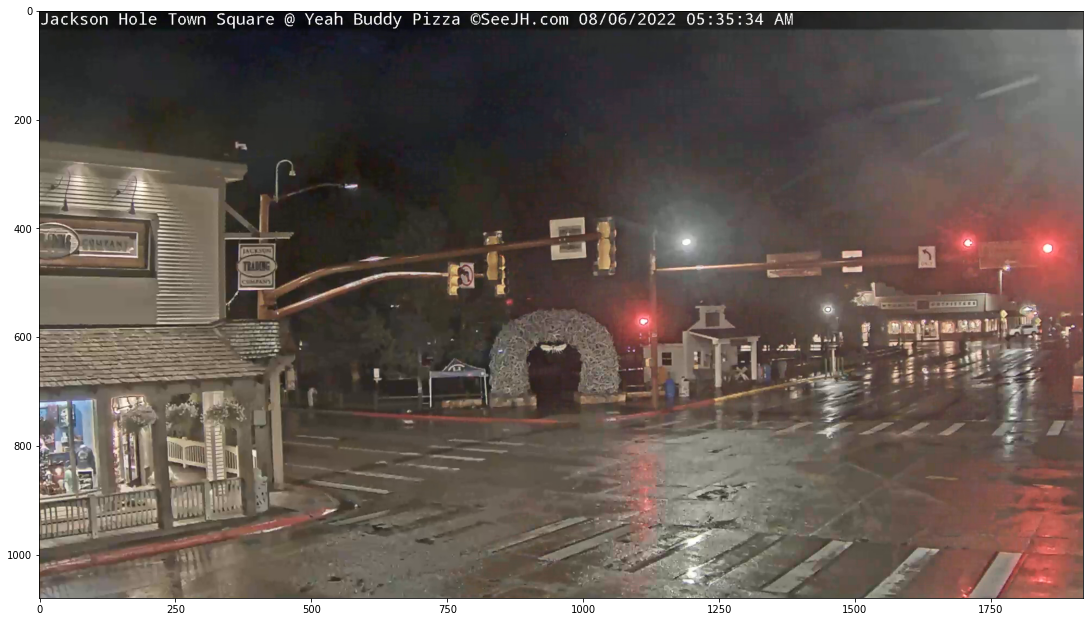

In [4]:
yt_dl_url = get_yt_dl_url(stream_url)

img = grab_frame(yt_dl_url)

show_image(img)

img_w_det, detections = detect_objects(detector, custom_objects, img, 70)


In [5]:
detections

[]

In [ ]:
s = sched.scheduler(time.time, time.sleep)

def run_object_detector(sc): 
    yt_dl_url = get_yt_dl_url(stream_url)

    img = grab_frame(yt_dl_url)

#     show_image(img)

    img_w_det, detections = detect_objects(detector, custom_objects, img, 70)

    if len(detections) > 0:

#         show_image(img_w_det)
        save_image(img_w_det, 'most_recent_detection.jpg')
        save_detections(engine, detections)
        
    sc.enter(30, 1, run_object_detector, (sc,))

s.enter(30, 1, run_object_detector, (s,))
s.run()


In [ ]:
import pytz
tz = pytz.timezone('US/Mountain')
datetime.now(tz=tz)

In [ ]:
pytz.all_timezones